# **Introducción**

Paquetes necesarios para instalar

In [ ]:
!pip3 install torch torchvision torchaudio

     |████████████████████████████████| 1.9MB 39.2MB/s 


Importando las bibliotecas

In [ ]:
import torch
from torchvision import datasets, utils
from torch import optim
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

Para utilizar una GPU en GoogleColab, primero hay que activarla. Los pasos a seguir, son los siguientes:

1. Ir y dar clic al botón Editar que aparece en la parte de arriba de esta libreta
2. Dar clic al la opción de Configuración del Notebook
3. Ubicar la opción de Acelerador de Hardware y se selecciona GPU

Haciendo los pasos anteriores, se corren nuevamente, las celdas pertinentes

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")

print(device)

cuda:0


# **Base de datos**

Primero, se descarga la base de datos a utilizar. Para los propósitos de este tutorial, MNIST es la indicada, la cual ya viene dividida en dos particiones, una para entrenar y la otra para validar algún modelo. MNIST (http://yann.lecun.com/exdb/mnist/) es una base de datos de imágenes de dígitos dibujados a mano

In [ ]:
path = './data'
train_data = datasets.MNIST(path, train = True, download = True)
val_data = datasets.MNIST(path, train = False, download = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Ahora separamos las imágenes de las etiquetas o clases. En este caso, queremos clasificar el dígito correspondiente a cada imagen. Ya sea 1, 2, 3 o el que esté dibujado. La variable $y$ para este ejercicio se corresponde con las etiquetas, que es la salida esperada que se requiere de la red,y la variable $X$
el conjunto de datos de entrada al modelo, ya sea para entrenar o para probar

In [ ]:
X_train, y_train = train_data.data, train_data.targets
X_test, y_test = val_data.data, val_data.targets

Para observar el tamaño de las imágenes, se ejecuta lo siguiente

In [ ]:
X_train[0].shape

torch.Size([28, 28])

Y para conocer la cantidad de imágenes que hay en cada conjunto

In [ ]:
print("El tamaño del conjunto de entrenamiento es", X_train.shape[0], "y el del conjunto de prueba", X_test.shape[0])

El tamaño del conjunto de entrenamiento es 60000 y el del conjunto de prueba 10000


Es decir:

*   El conjunto de entrenamiento tiene 60000 imágenes de $28 \times 28$.
*   El conjunto de prueba tiene 10000 imágenes de $28 \times 28$.

Las etiquetas de entrenamiento son un tensor unidemensional de 60000 valores, mientras que las etiquetas de prueba son un tensor unidimensional de 10000 valores. Es decir, en ambos casos se tiene un prisma de $28 \times 28$ con una profundidad correspondiente al tamaño de cada conjunto, respectivamente

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

También las etiquetas son un tensor, con un tamaño correspondiente al de cada conjunto

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

# **Pre-procesamiento**

Nuestras imágenes deberán pasar por un proceso que ajuste el formato actual de nuestros datos al formato que PyTorch necesita para operar. En el estado actual, cada imágen está en blanco y negro, es decir, sólo hay un canal (profundidad igual a $1$). Por ello, los datos tienen la forma $(N, H, W)$, donde:

*  $N$: número de imágenes
*  $H$: altura de las imágenes (número de filas en la matriz)
*  $W$: ancho de las imágenes (número de columnas en la matriz)

Es como si todas las imágenes se apilaran para formar un gran *volumen*.

En PyTorch, sin embargo, el número de canales debe estar explícitamente representado en el tamaño del tensor. Específicamente, la forma de este tensor debe tener el formato $(N, C, H, W)$, donde $C$ es el número de canales. En nuestro ejemplo, $C = 1$. Si las imágenes fueran a color (formato RGB), el valor sería $C = 3$. 

PyTorch nos permite reconfigurar nuestros tensores para ajustarse a este nuevo formato

In [ ]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

Y la nueva forma del tensor es

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

Con nuestros datos ya en el órden espacial que necesitamos, podemos visualizarlos. Crearemos una función que muestre algunos ejemplos de las imágenes que tenemos

In [ ]:
'''Función de visualización de imágenes'''
def show(img):
  npimg = img.numpy()

  #Convertimos las imágenes al formato (H, W, C)
  npimg_tr = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg_tr, interpolation = 'nearest')

Para el ejemplo, tomaremos 40 imágenes colocadas en una matriz de $5 \times 8$

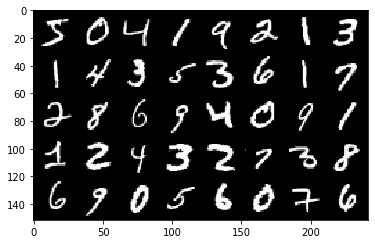

In [ ]:
x_grid = utils.make_grid(X_train[:40], nrow = 8, padding = 2)
show(x_grid)

Una sola imagen

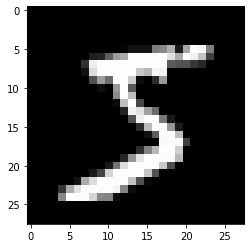

In [ ]:
x_grid = utils.make_grid(X_train[:1], nrow = 8, padding = 2)
show(x_grid)

En PyTorch, hay dos objetos importantes, ```dataset``` y ```dataloader```. Estos objetos funcionan como organizadores e **iteradores** para nuestros datos. Al momento de pasar los datos por la CNN, el ```dataloader``` se encarga de iterar sobre ellos para evitar que todos esten abiertos al mismo tiempo

In [ ]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)

print("Esto es una imagen:", train_ds[0][0].shape)

Esto es una imagen: torch.Size([1, 28, 28])


Ahora, convertiremos nuestros objetos ```dataset``` en objetos ```dataloader```. Es importante notar que el ```dataloader``` nos pide un tamaño de **batch**. Es decir, que en lugar de pasar imagen por imagen a nuestra red, pasaremos grupos de imágenes llamados batches. La función de error se calcula para todo el batch y se promedia en función de su tamaño.

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 8)
test_dl = DataLoader(test_ds, batch_size = 8)

for xb, yb in test_dl:
  print("Esto es un batch de 8 imágenes:", xb.shape)
  print("Cada imagen con su respectiva etiqueta:", yb.shape)
  break

Esto es un batch de 8 imágenes: torch.Size([8, 1, 28, 28])
Cada imagen con su respectiva etiqueta: torch.Size([8])


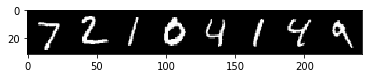

In [ ]:
x_grid = utils.make_grid(xb, nrow = 8, padding = 2)
show(x_grid)

In [ ]:
yb

tensor([7, 2, 1, 0, 4, 1, 4, 9])

In [ ]:
def conv_out_dims(inpt, kernel_size, stride):
    res1 = np.floor((inpt[0] + 0 - 1 * (kernel_size[0] - 1) - 1)/stride[0] + 1)
    res2 = np.floor((inpt[1] + 0 - 1 * (kernel_size[1] - 1) - 1)/stride[1] + 1)

    return [int(res1), int(res2)]

def pool_out_dims(inpt, kernel_size, stride):
    res1 = np.floor((inpt[0] + 0 - 1 * (kernel_size[0] - 1) - 1)/stride[0] + 1)
    res2 = np.floor((inpt[1] + 0 - 1 * (kernel_size[1] - 1) - 1)/stride[1] + 1)

    return [int(res1), int(res2)]

In [ ]:
print(conv_out_dims([28, 28], [3, 3], [2, 2]))
print(pool_out_dims([13, 13], [2, 2], [1, 1]))
print(conv_out_dims([12, 12], [3, 3], [2, 2]))
print(pool_out_dims([5, 5], [2, 2], [1, 1]))
50*4*4

[13, 13]
[12, 12]
[5, 5]
[4, 4]


800

# **Red Neuronal Convolucional**

PyTorch tiene la característica de tener una funcionamiento muy similar a Python puro. En este sentido, la creación de una red neuronal implica crear una clase. Estas clases heredan propiedades de la clase ```nn.Module```. La clase debe tener dos partes esenciales: 

*   ```__init__```: en donde se definen las partes que componen a nuestra CNN. 
*   ```forward```: el método que define el comportamiento de la CNN, utilizando los componentes disponibles en ```__init__```.

In [ ]:
'''Creado una CNN'''
class Net(nn.Module):
  #Método _init_ para inicializar la red
  def __init__(self):
    super(Net, self).__init__()
    #A continuación podemos definir los elementos que tenrá nuestra red
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 3, stride = 2)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 1)

    self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = 3, stride = 2)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 1)

    self.fc1 = nn.Linear(in_features = 800, out_features = 500)
    self.relu3 = nn.ReLU()

    self.fc2 = nn.Linear(in_features = 500, out_features = 10)
    self.relu4 = nn.ReLU()

  #Método forward para definir el paso hacia adelante
  def forward(self, x): #La variable x representa a la entrada de la red (un batch)
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = torch.flatten(x, 1) #Convertimos el último mapa de activación en un vector
    
    x = self.fc1(x)
    x = self.relu3(x)
    
    x = self.fc2(x)
    x = F.log_softmax(x, dim = 1) #Función de activación softmax que utilizaremos para clasificación multi-clase

    return x

Analicemos los elementos que utilizamos:

*  ```Conv2d```: se usa para las capas de convolución. Los parámetros que usamos son (número de canales de entrada, número de filtros, tamaño de los kernels que cada filtro, stride) en el órden de lo que aparece en el código.
*  ```MaxPool2d```: se usa para el Max Pooling. Los parámetros que usamos son (tamaño del kernel, stride).
*  ```Linear```: se usa para las capas de neuronas (fully-connected). Los parámetros que usamos son (número de valores de entrada, número de neuronas en la capa). Es importante notar que la primera capa fully-connected tiene tantos datos de entrada como sea el número de "píxeles" en el último mapa de activación

In [ ]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu4): ReLU()
)


Para poder aprovechar la GPU, tenemos que enviar nuestra CNN a la GPU. En estos momentos, todo lo que hemos hecho se encuentra en la CPU de la máquina virtual de Google Colab.

In [ ]:
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu4): ReLU()
)

Una vez en la GPU, podemos usar la herramienta ```summary``` para desplegar información valiosa sobre nuestra red, como los tamaños de salida de cada capa, y el número de parámetros totales de nuestra red

In [ ]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 13, 13]             200
              ReLU-2           [-1, 20, 13, 13]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 5, 5]           9,050
              ReLU-5             [-1, 50, 5, 5]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 500]         400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
Total params: 414,760
Trainable params: 414,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 1.69
-------------------------------------------

# **Entrenamiento de la red**

Ya que la CNN está lista, podemos comenzar a definir las características de nuestro entrenamiento. Primero, una función de pérdida

In [ ]:
loss_func = nn.CrossEntropyLoss()

El optimizador

In [ ]:
opt = optim.Adam(model.parameters(), lr = 1e-4)

Y, finalmente, el número de épocas en las que se va a entrenar la red

In [ ]:
num_epochs = 10

Con estos hiperparámetros ya definidos,podemos escribir nuestro **loop** de entrenamiento

In [ ]:
for epoch in range(num_epochs):
  '''Entrenamiento'''
  #Ponemos a nuestro modelo en modo entrenamiento
  model.train()

  #Inicializamos función de pérdida y accuracy de entrenamiento
  loss_t = 0.0
  acc_t = 0.0

  #Obtenemos el número de datos de entrenamiento
  len_data = len(train_dl.dataset)

  #Iteramos sobre los batches de entrenamiento (train_dl)
  for xb, yb in train_dl:
    #Movemos el batch y las etiquetas a la GPU
    xb = xb.type(torch.float).to(device)
    yb = yb.to(device)

    #Obtenemos la predicción de la red
    yb_h = model(xb)

    #Calculamos valor de la función de pérdida
    loss_b = loss_func(yb_h, yb)

    #Optimizamos (paso hacia atrás)
    loss_b.backward()
    opt.step()
    opt.zero_grad()

    #Obtenemos el accuracy de este batch
    pred = yb_h.argmax(dim = 1, keepdim = True) #Obtebemos las probabilidades máximas de cada batch
    acc_b = pred.eq(yb.view_as(pred)).sum().item() #Comparamos las predicciones con las etiquetas

    #Actualizamos la pérdida y accuracy totales de entrenamiento
    loss_t += loss_b.item()
    if acc_b is not None:
        acc_t += acc_b
  
  #Promediamos la pérdida y accuracy de entrenamiento
  loss_t /= len_data
  acc_t /= len_data

  '''Validación'''
  #Inicializamos función de pérdida y accuracy de prueba
  loss_v = 0.0
  acc_v = 0.0

  #Obtenemos el número de datos de prueba
  len_data = len(test_dl.dataset)

  #Ponemos a nuestro modelo en modo evaluación
  model.eval()

  #Especificamos que para utilizar los datos de prueba, PyTorch no calcule ningún gradiente
  with torch.no_grad(): 
    #Iteramos sobre los batches de prueba (test_dl)
    for xb, yb in test_dl:
      #Movemos el batch y las etiquetas a la GPU
      xb = xb.type(torch.float).to(device)
      yb = yb.to(device)

      #Obtenemos la predicción de la red
      yb_h = model(xb)

      #Calculamos valor de la función de pérdida
      loss_b = loss_func(yb_h, yb)

      #Obtenemos el accuracy de este batch
      pred = yb_h.argmax(dim = 1, keepdim = True) #Obtebemos las probabilidades máximas de cada batch
      acc_b = pred.eq(yb.view_as(pred)).sum().item() #Comparamos las predicciones con las etiquetas

      #Actualizamos la pérdida y accuracy totales de prueba
      loss_v += loss_b.item()
      if acc_b is not None:
        acc_v += acc_b

    #Promediamos la pérdida y accuracy de entrenamiento
    loss_v /= len_data
    acc_v /= len_data

    print('Época: %d, Pérdida de entrenamiento: %.5f, Pérdidad de prueba: %.5f, Accuracy de entrenamiento: %.4f, Accuracy de prueba: %.4f'
          %(epoch, loss_t, loss_v, acc_t, acc_v))

Época: 0, Pérdida de entrenamiento: 0.02914, Pérdidad de prueba: 0.01543, Accuracy de entrenamiento: 0.9337, Accuracy de prueba: 0.9601
Época: 1, Pérdida de entrenamiento: 0.00969, Pérdidad de prueba: 0.00739, Accuracy de entrenamiento: 0.9762, Accuracy de prueba: 0.9810
Época: 2, Pérdida de entrenamiento: 0.00565, Pérdidad de prueba: 0.00967, Accuracy de entrenamiento: 0.9863, Accuracy de prueba: 0.9774
Época: 3, Pérdida de entrenamiento: 0.00379, Pérdidad de prueba: 0.00885, Accuracy de entrenamiento: 0.9905, Accuracy de prueba: 0.9807
Época: 4, Pérdida de entrenamiento: 0.00289, Pérdidad de prueba: 0.00827, Accuracy de entrenamiento: 0.9925, Accuracy de prueba: 0.9845


KeyboardInterrupt: ignored

Para resetear los parámetros de la red

In [ ]:
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

# **Clasificar imágenes mediante Inception v3**

### **Importar librerías**

In [ ]:
from keras.applications.inception_v3 import InceptionV3 #Cargar CNN pre-entrenada Inception v3
from keras.applications.inception_v3 import preprocess_input #Función para procesar imágenes para su correcta entrada en la CNN
from keras.applications.inception_v3 import decode_predictions #Función para decodificar el nombre de la clase predecida
import numpy as np #Librería para procesar arreglos y tensores
import matplotlib.pyplot as plt #Librería para graficar
%matplotlib inline
import cv2 #Librería para procesar imágenes
import urllib.request as req #Librería para cargar vínculos de internet

#Librería Tensorflow y su API Keras. Importar capas neuronales.
import tensorflow as tf
import keras
from keras import models 
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, InputLayer, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU

#Librería PyTorch.
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary

#Librería ppara mostrar el progreso de los entrenamientos.
from tqdm.auto import tqdm
#Librería para limpiar las visualizaciones
from IPython import display

### **Carga del model pre-entrenado Inception v3**

In [ ]:
modelo = InceptionV3(weights='imagenet', include_top=True)

96124928/96112376 [==============================] - 0s 0us/step


### **Predicción de clase mediante Inception v3**

49152/35363 [=========================================] - 0s 0us/step


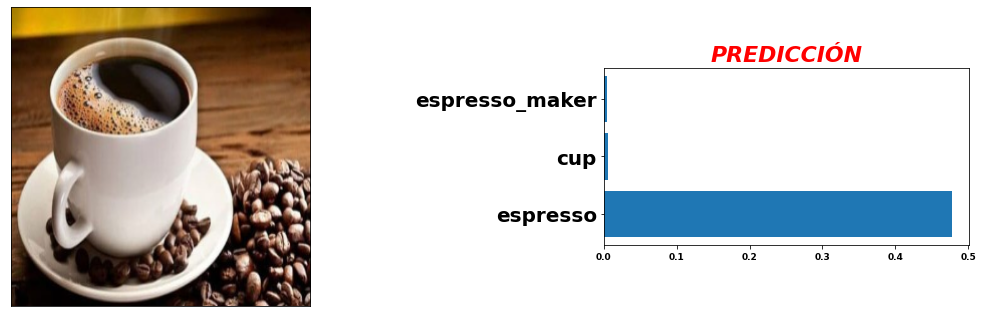

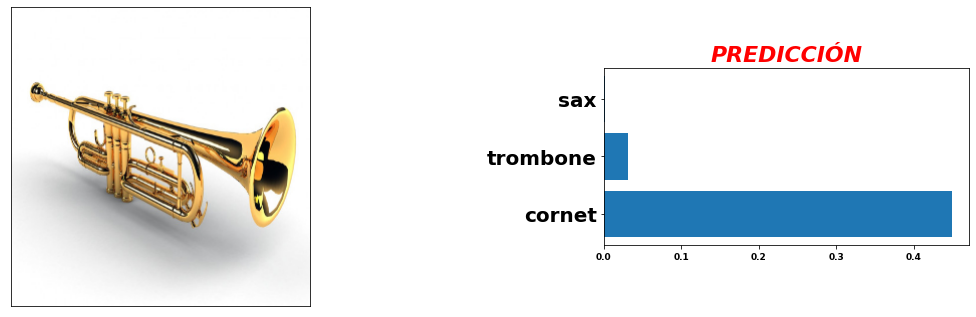

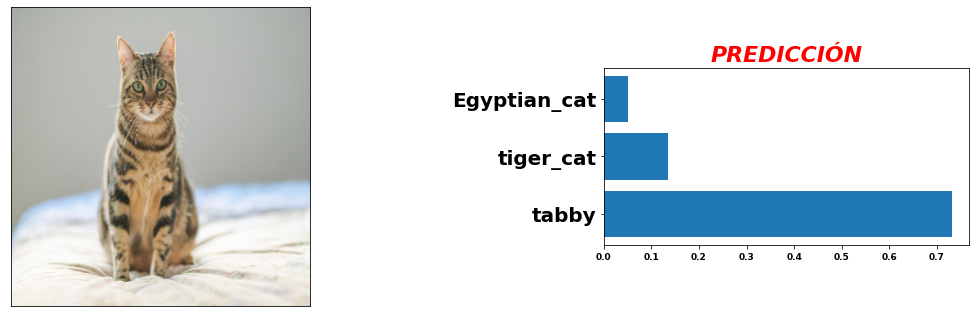

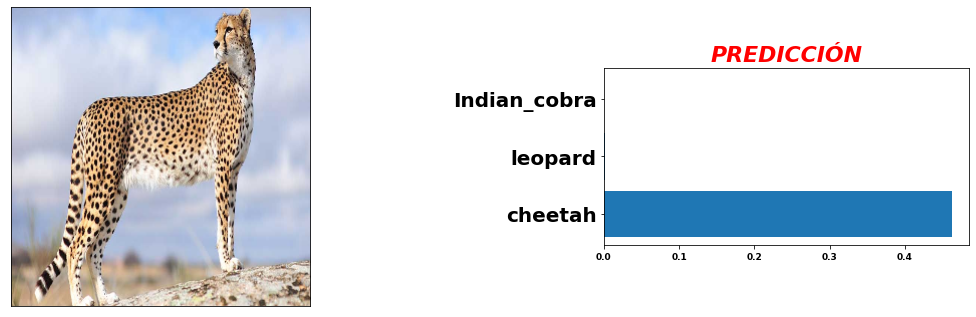

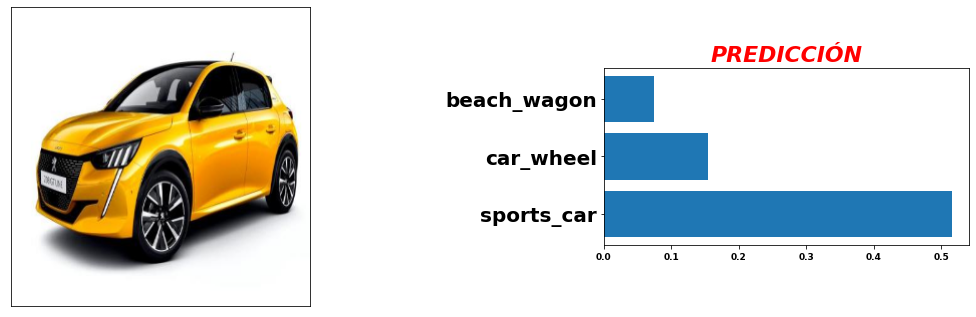

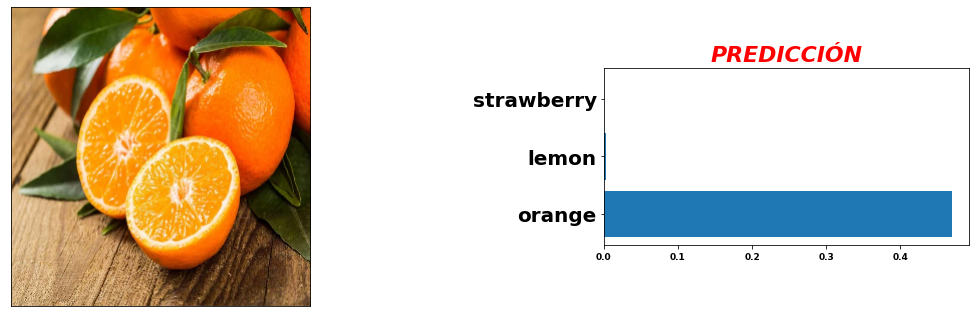

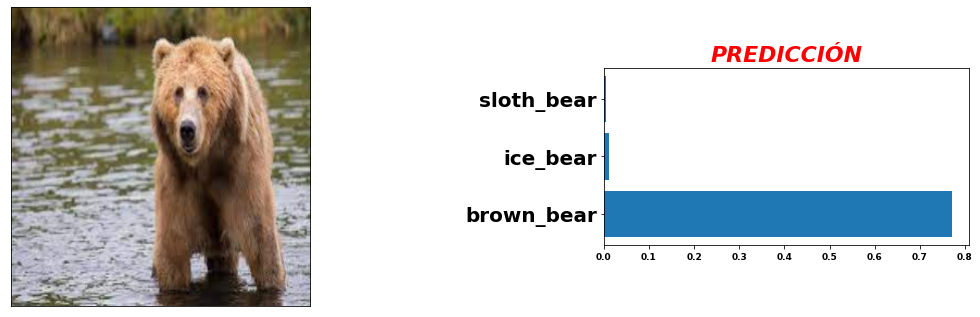

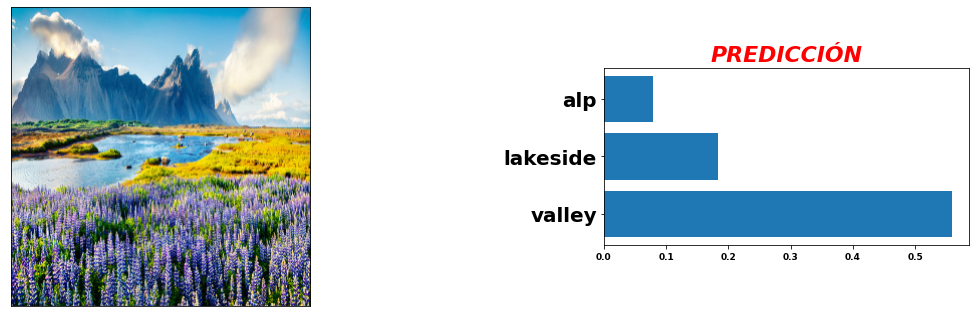

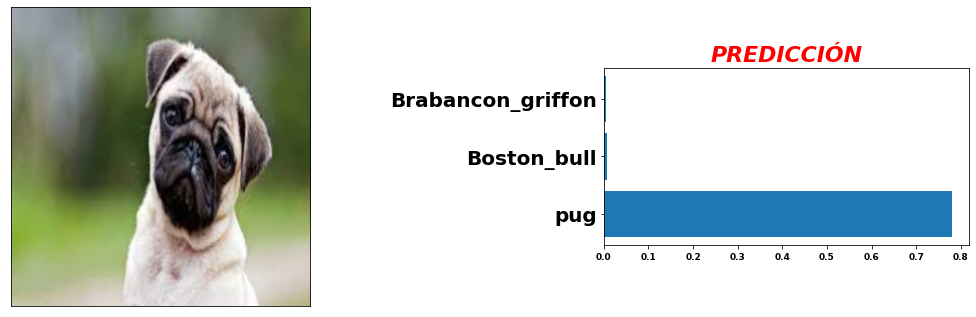

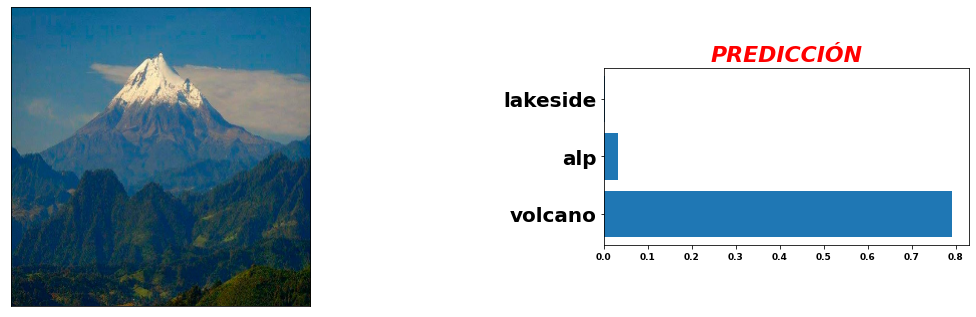

In [ ]:
direccion = 'https://raw.githubusercontent.com/GustavoVargasHakim/ENC2021-Neuroevolucion/main/Images2/imagen_' #Repositorio donde se encuentran las imágenes
for i in range(1,11):
  #Nombre de la imagen
  nombre = direccion+str(i)+'.jpg'
  #URL de la imagen en el repositorio GITHUB
  url = req.urlopen(nombre)
  #Cargar y convertir en arreglo la imagen
  arreglo = np.asarray(bytearray(url.read()), dtype=np.uint8)
  imagen = cv2.imdecode(arreglo, -1)
  #Cambiar de BGR a RGB
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  #Redimensionar la imagen a (1,299,299,3) porque es la entrada de Inception v3
  imagen = cv2.resize(imagen,(299, 299))
  imagen = np.expand_dims(imagen, axis = 0).astype(np.float32)*2./255.0 -1. #Se normaliza en un rango de [-1,1] ya que es la entrada correcta a la CNN
  #Obtención de las predicciones obtenidas por Inception v3 al insertar la imagen
  caracteristicas = modelo.predict(imagen)
  #Obtención de las tres clases más probables obtenidas por la CNN
  predicciones = np.array(decode_predictions(caracteristicas, top = 3)[0])
  #Nombres de las clases de las tres principales predicciones
  clases = predicciones[:,1]
  #Probabilidades de las clases más probables
  probabilidades = predicciones[:,2].astype('float64')

  #GRAFICAR IMÁGEN Y GRÁFICO DE BARRAS DE LAS PREDICCIONES#
  #Tamaño del gráfico
  fig = plt.figure()
  fig.set_figheight(10)
  fig.set_figwidth(20)
  #Gráfica uno para plasmar la imagen
  grafica_1 = plt.subplot2grid(shape=(18, 18), loc=(2, 12), colspan=8, rowspan=6)
  #Gráfica dos para mostrar las probabilidades
  grafica_2 = plt.subplot2grid(shape=(18, 18), loc=(0, 0), colspan=10,rowspan=10)
  grafica_2.grid(False) #Eliminar cuadrícula
  #Eliminar marcas de ejes
  grafica_2.set_xticks([])
  grafica_2.set_yticks([])
  #Crear gráfico de barras para las clases de las predicciones
  grafica_1.barh(clases,probabilidades)
  grafica_1.set_yticklabels(clases,fontsize=20,fontweight='bold')
  grafica_1.set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],fontsize=9,fontweight='bold')
  grafica_1.set_title('PREDICCIÓN',fontweight='bold', style='italic', fontsize=22,color='r')
  #Visualizar imagen introducida a la CNN
  grafica_2.imshow((imagen[0,:,:,:]*127.5+127.5).astype(np.uint8), vmin=0, vmax=255)
  plt.show()

# **Generative Adversarial Networks (GANs)**

### **Fijar semillas de aleatoriedad para garantizar los mismos resultados**

In [ ]:
#Semillas alaeatorias de ambas paqueterías de RN para garantizar los mismos resultados
torch.manual_seed(0) 
tf.random.set_seed(0)

### **Parámetros necesesarios**

In [ ]:
criterio = nn.BCEWithLogitsLoss() #Función de pérdida para PyTorch
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Función de pérdida para Tensorflow
z_dim = 100 #Número de digitos aleatorios de entrada al Generador
tamaño_lote = 128 #Tamaño de lote
tasa_aprendizaje = 0.0002 #Tasa de aprendizaje de los optimizadores de las RN
#Parámetros del optimizador Adam
beta_1 = 0.5 
beta_2 = 0.999
dispositivo = 'cuda' #Indicación de usar GPU en lugar de CPU para entrenar
numero_epocas = 100 #Número de épocas para entrenar la GAN
num_ejemplos = 25 #Número de ejemplos a visualizar durante el entrenamiento
num_canales = 1 #Número de canales de las imágenes generadas (1 canal: escala de grises)
dimension_oculta = 64 #Número para definir el número de filtros de las diferentes capas del Generador y Discriminador
dimension_MNIST = 28 #Alto y Largo de las imágenes de MNIST

### **Función para mostrar los lotes de imágenes de ejemplo durante el entrenamiento**

In [ ]:
#Función para mostrar lotes de imágenes
def mostrar_imagen(predicciones,libreria):
  fig = plt.figure(figsize=(5,5))
  predicciones1 = predicciones[:25]
  if libreria == 'tf':
    image_tensor = (torch.tensor(predicciones1.numpy().reshape(-1,1,28,28))+ 1)/2
    image_grid = make_grid(image_tensor[:25], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
  
  else:
    image_tensor = (predicciones1+ 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:25], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
  plt.show()

### **Obtener conjunto MNIST y procesarlo para las diferentes librerías**

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


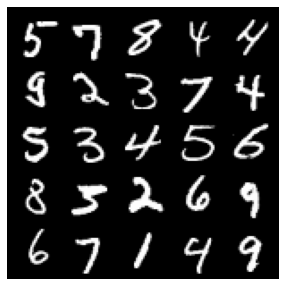

In [ ]:
#####CONJUNTO DE IMÁGENES PARA PYTORCH#####
#Obtener imágenes del conjunto de datos MNIST
imagenes_pt = MNIST('.', download=True,train=True).data.numpy()
#Normalizar las imágenes en un rango de [-1,1]
imagenes_pt= imagenes_pt.reshape(-1,1,28,28).astype(np.float32)*2./255.0 -1.
#Crear el conjunto de datos para el entrenamiento de las GANs en PyTorch
dataset_pt = DataLoader(imagenes_pt,
    batch_size=tamaño_lote,
    shuffle=True)

#####CONJUNTO DE IMÁGENES PARA TENSORFLOW#####
#Ajustar el tamaño del arreglo de imágenes para usarse en Tensorflow
imagenes_tf = imagenes_pt.reshape(-1,28,28,1)
#Crear el conjunto de datos para el entrenamiento de las GANs en Tensorflow
dataset_tf = tf.data.Dataset.from_tensor_slices(imagenes_tf).shuffle(imagenes_tf.shape[0]).batch(tamaño_lote,drop_remainder=False).prefetch(1)

#Mostrar ejemplos de la base MNIST
mostrar_imagen(next(iter(dataset_tf)), 'tf')

## **GAN en PyTorch**

### **Clase para crear al Generador**

In [ ]:
#Clase para definir al generador
class Generador_pytorch(nn.Module):
    def __init__(self, z_dim, num_canales, dimension_oculta):
        super(Generador_pytorch, self).__init__()
        self.z_dim = z_dim
        #Insertar bloques compuestos por capa transpuesta convolucional + capa Batch normalization + capa ReLU 
        #Si es la capa final, sólo se usa la capa transpuesta convolucional + Tanh
        self.gen = nn.Sequential(
            self.obtener_bloque_gen(z_dim, dimension_oculta * 4),
            self.obtener_bloque_gen(dimension_oculta * 4, dimension_oculta * 2, tamaño_filtro=4, stride=1),
            self.obtener_bloque_gen(dimension_oculta * 2, dimension_oculta),
            self.obtener_bloque_gen(dimension_oculta, num_canales, tamaño_filtro=4, capa_final=True),
        )

    def obtener_bloque_gen(self, canales_entrada, canales_salida, tamaño_filtro=3, stride=2, capa_final=False):
        if not capa_final:
            return nn.Sequential(
                
                nn.ConvTranspose2d(canales_entrada, canales_salida, tamaño_filtro, stride),
                nn.BatchNorm2d(canales_salida),
                nn.ReLU()
               
            )
        else: 
            return nn.Sequential(
                
                nn.ConvTranspose2d(canales_entrada, canales_salida, tamaño_filtro,stride),
                nn.Tanh()
                
            )

    def regresar_ruido(self, ruido):
        return ruido.view(len(ruido), self.z_dim, 1, 1)

    def forward(self, ruido):
        x = self.regresar_ruido(ruido)
        return self.gen(x)

### **Clase para crear el Discriminador**

In [ ]:
#Clase para definir al Discriminador
class Discriminador_pytorch(nn.Module):
    def __init__(self, num_canales, dimension_oculta):
        super(Discriminador_pytorch, self).__init__()
        #Se insertan bloques de capas compuestos por una capa convolucional + capa Batch Normalization + capa LeakyReLU
        #Si es la capa final de la red sólo lleva la capa convolucional
        self.disc = nn.Sequential(
            self.obtener_bloque_disc(num_canales, dimension_oculta),
            self.obtener_bloque_disc(dimension_oculta, dimension_oculta * 2),
            self.obtener_bloque_disc(dimension_oculta * 2, 1, capa_final=True),
        )

    def obtener_bloque_disc(self, canales_entrada, canales_salida, tamaño_filtro=4, stride=2, capa_final=False):
        if not capa_final:
            return nn.Sequential(
                
                nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro,stride),
                nn.BatchNorm2d(canales_salida),
                nn.LeakyReLU(0.2)
                  
                
            )
        else: 
            return nn.Sequential(
                
                nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro,stride)
               
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### **Función para obtener ruido aleatorio**

In [ ]:
#Función para obtener el ruido aleatorio normal que será la entrada al generador
def obtener_ruido_pt(num_muestras, z_dim, dispositivo='cpu'):
    return torch.randn(num_muestras, z_dim, device=dispositivo)

### **Función para inicializar pesos de las redes**

In [ ]:
#Función para inicializar los pesos de las redes
def iniciar_pesos(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

### **Crear, inicializar y mostrar arquitectura del Generador, así como su optimizador**

In [ ]:
#Obtener generador
generador_pt = Generador_pytorch(z_dim, num_canales, dimension_oculta).to(dispositivo)
#Inicializar pesos del generador
generador_pt = generador_pt.apply(iniciar_pesos)
#Crear optimizador (Adam) para el generador
gen_pt_opt = torch.optim.Adam(generador_pt.parameters(), lr=tasa_aprendizaje, betas=(beta_1, beta_2))
#Mostrar arquitectura del generador
summary(generador_pt,input_size=(1,z_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### **Crear, inicializar y mostrar arquitectura del Discriminador, así como su optimizador**

In [ ]:
#Obtener discriminador
discriminador_pt = Discriminador_pytorch(num_canales, dimension_oculta).to(dispositivo)
#Inicializar pesos del discriminador
discriminador_pt = discriminador_pt.apply(iniciar_pesos)
#Crear optimizador (Adam) para el discriminador
disc_pt_opt = torch.optim.Adam(discriminador_pt.parameters(), lr=tasa_aprendizaje, betas=(beta_1, beta_2))
#Mostrar arquitectura del discriminador
summary(discriminador_pt,input_size=(1,dimension_MNIST,dimension_MNIST))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


### **Función para realizar un paso de entrenamiento**

In [ ]:
def paso_entrenamiento_pt(imagenes):
  tamaño_lote_actual = len(imagenes)
  imagenes = imagenes.to(dispositivo)
  ## Actualizar discriminador ##
  disc_pt_opt.zero_grad()
  ruido_falso = obtener_ruido_pt(tamaño_lote_actual, z_dim, dispositivo=dispositivo)
  falso = generador_pt(ruido_falso)
  pred_disc_falso = discriminador_pt(falso.detach())
  perd_pred_disc_falso = criterio(pred_disc_falso, torch.zeros_like(pred_disc_falso))
  pred_disc_real = discriminador_pt(imagenes)
  perd_pred_disc_real= criterio(pred_disc_real, torch.ones_like(pred_disc_real))
  perdida_discriminador = (perd_pred_disc_falso + perd_pred_disc_real) / 2
  # Actualizar gradientes
  perdida_discriminador.backward(retain_graph=True)
  # Actualizar optimizador
  disc_pt_opt.step()

  ## Actualizar generador ##
  gen_pt_opt.zero_grad()
  ruido_falso_2 = obtener_ruido_pt(tamaño_lote_actual, z_dim, dispositivo=dispositivo)
  falso_2 = generador_pt(ruido_falso_2)
  pred_disc_falso = discriminador_pt(falso_2)
  perdida_generador = criterio(pred_disc_falso, torch.ones_like(pred_disc_falso))
  #Actualizar gradientes
  perdida_generador.backward()
  #Actualizar generador
  gen_pt_opt.step()


### **Función para realizar el entrenamiento de la GAN**

In [ ]:
def entrenamiento_pt(dataset,numero_epocas):
  #Por el número de épocas definido
  for epoca in range(numero_epocas):
    #Por cada mini-lote de imágenes del conjunto de imágenes completo
      for real in tqdm(dataset):
        paso_entrenamiento_pt(real)
      imagenes_generadas = generador_pt(semilla_pt)
      #Mostrar lotes de imagenes sintéticas y reales
      display.clear_output(wait=True)
      print(f"Época {epoca+1}")
      print('Imágenes sintéticas')
      mostrar_imagen(imagenes_generadas,'pt')
      print('Imágenes reales')
      mostrar_imagen(real,'pt')

### **Entrenar la GAN**

Época 5
Imágenes sintéticas


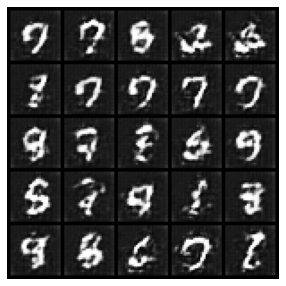

Imágenes reales


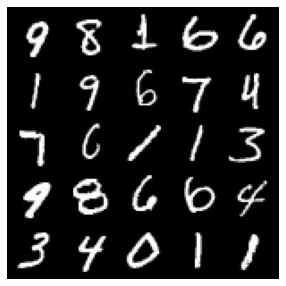

In [ ]:
#Obtener valores aleatorios fijos que se irán introduciendo en el generador conforme avanza el entrenamiento para notar la mejora
semilla_pt = obtener_ruido_pt(num_ejemplos, z_dim, dispositivo=dispositivo) 
#Entrenamiento de la GAN
entrenamiento_pt(dataset_pt,numero_epocas)
        

## **GAN en Tensorflow**

### **Inicializador de pesos de las redes**

In [ ]:
#Método para inicializar los pesos de las redes 
inicializador_pesos_tf = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

### **Función para crear el Generador**

In [ ]:
#Función para obtener el Generador en Tensorflow
def generador_tensorflow():
  modelo = models.Sequential()
  modelo.add(keras.Input(shape=(1, 1, 100), name='input_layer'))
  modelo.add(Conv2DTranspose(dimension_oculta * 4, kernel_size=3, strides= 3, padding='same', kernel_initializer=inicializador_pesos_tf, use_bias=False, name='conv_transpose_1',dtype='float32'))
  modelo.add(BatchNormalization(momentum=0.1,  epsilon=1e-05, center=True, scale=True, name='bn_1',dtype='float32'))
  modelo.add(ReLU(name='relu_1'))
  modelo.add(Conv2DTranspose(dimension_oculta * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=inicializador_pesos_tf, use_bias=False, name='conv_transpose_2', dtype='float32'))
  modelo.add(BatchNormalization(momentum=0.1,  epsilon=1e-05, center=True, scale=True, name='bn_2', dtype='float32'))
  modelo.add(ReLU(name='relu_2'))
  modelo.add(Conv2DTranspose(dimension_oculta , kernel_size=3, strides= 2, padding='valid', kernel_initializer=inicializador_pesos_tf, use_bias=False, name='conv_transpose_3', dtype='float32'))
  modelo.add(BatchNormalization(momentum=0.1,  epsilon=1e-05, center=True, scale=True, name='bn_3', dtype='float32'))
  modelo.add(ReLU(name='relu_3'))
  modelo.add(Conv2DTranspose(num_canales, kernel_size=4, strides= 2, padding='valid', kernel_initializer=inicializador_pesos_tf, use_bias=False, activation= 'tanh', name='conv_transpose_4', dtype='float32'))
  return modelo 


### **Función para crear el Discriminador**

In [ ]:
#Función para obtener el discriminador en Tensorflow
def discriminador_tensorflow():
  modelo = models.Sequential()
  modelo.add(keras.Input(shape=(28, 28, 1), name='input_layer'))

  modelo.add(Conv2D(dimension_oculta, kernel_size=4, strides= 2, padding='valid', kernel_initializer=tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=0.02), use_bias=False, name='conv_1',dtype='float32'))
  modelo.add(BatchNormalization(momentum=0.1,  epsilon=1e-05, center=True, scale=True, name='bn_1',dtype='float32'))
  modelo.add(LeakyReLU(alpha=0.01,name='Lrelu_1'))

  modelo.add(Conv2D(dimension_oculta * 2, kernel_size=4, strides= 2, padding='valid', kernel_initializer=tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=0.02), use_bias=False, name='conv_2', dtype='float32'))
  modelo.add(BatchNormalization(momentum=0.1,  epsilon=1e-05, center=True, scale=True, name='bn_2', dtype='float32'))
  modelo.add(LeakyReLU(alpha=0.01,name='Lrelu_2'))

  modelo.add(Conv2D(num_canales, kernel_size=4, strides= 2, padding='valid', kernel_initializer=tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=0.02), use_bias=False, activation= 'sigmoid', name='conv_3', dtype='float32'))
  modelo.add(keras.layers.Reshape(target_shape=(1,)))
  return modelo

### **Crear, inicializar y mostrar arquitectura del Generador, así como su optimizador**

In [ ]:
generador_tf = generador_tensorflow() #Crear e inicializar el generador
generador_optimizador = tf.keras.optimizers.Adam(learning_rate = tasa_aprendizaje, beta_1 = beta_1, beta_2 = beta_2) #Inicializar optimizador del generador
generador_tf.summary() #Mostrar arquitectura del generador

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_transpose_1 (Conv2DTran (None, 3, 3, 256)         230400    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 3, 3, 256)         1024      
_________________________________________________________________
relu_1 (ReLU)                (None, 3, 3, 256)         0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 6, 6, 128)         524288    
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 6, 6, 128)         512       
_________________________________________________________________
relu_2 (ReLU)                (None, 6, 6, 128)         0         
_________________________________________________________________
conv_transpose_3 (Conv2DTran (None, 13, 13, 64)        7

### **Crear, inicializar y mostrar arquitectura del Discriminador, así como su optimizador**

In [ ]:
discriminador_tf = discriminador_tensorflow() #Crear e inicializar dicriminador
discriminador_optimizador = tf.keras.optimizers.Adam(learning_rate = tasa_aprendizaje, beta_1 = beta_1, beta_2 = beta_2) #Inicializar optimizador del discriminador
discriminador_tf.summary() #Mostrar arquitectura del discriminador

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 13, 13, 64)        1024      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 13, 13, 64)        256       
_________________________________________________________________
Lrelu_1 (LeakyReLU)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 5, 5, 128)         131072    
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 5, 5, 128)         512       
_________________________________________________________________
Lrelu_2 (LeakyReLU)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 1, 1, 1)          

### **Función de pérdida del discriminador**

In [ ]:
# Pérdida del discriminador
def discriminador_perdida(salida_real, salida_falsa):
    perdida_real = cross_entropy(tf.ones_like(salida_real), salida_real)
    perdida_falsa = cross_entropy(tf.zeros_like(salida_falsa), salida_falsa)
    perdida_total = perdida_real + perdida_falsa
    return perdida_total

### **Función de pérdida del generador**

In [ ]:
#Pérdida del generador
def generador_perdida(salida_falsa):
    return cross_entropy(tf.ones_like(salida_falsa), salida_falsa)

### **Función para obtener ruido aleatorio de entrada al generador**

In [ ]:
#Función para obtener ruido aleatorio normal de entrada al generador
def obtener_ruido_tf(num_ejemplos,z_dim):
  return tf.random.normal([num_ejemplos, 1, 1, z_dim])

### **Función para hacer un paso de entrenamiento**

In [ ]:
#Función para realizar un paso en el entrenamiento de las GANs
@tf.function
def paso_entrenamiento_tf(imagenes):
    tamaño_lote_actual = imagenes.shape[0]
    ruido = obtener_ruido_tf(tamaño_lote_actual, z_dim) #Obtener ruidp
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Calcular pérdidas
      imagenes_generadas = generador_tf(ruido, training=True)

      salida_real = discriminador_tf(imagenes, training=True)
      salida_falsa = discriminador_tf(imagenes_generadas, training=True)

      perd_generador = generador_perdida(salida_falsa)
      perd_discriminador = discriminador_perdida(salida_real, salida_falsa)
    #Calcular gradientes con las pérdidas
    gradientes_generador = gen_tape.gradient(perd_generador, generador_tf.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(perd_discriminador, discriminador_tf.trainable_variables)
    #Actualizar optimizadores
    generador_optimizador.apply_gradients(zip(gradientes_generador, generador_tf.trainable_variables))
    discriminador_optimizador.apply_gradients(zip(gradientes_discriminador, discriminador_tf.trainable_variables))

### **Función para realizar el enetrenamiento de la GAN**

In [ ]:
def entrenamiento_tf(dataset, epocas):
  #Por cada época
  for epoca in range(epocas):
    #Por cada mini-lote en el conjunto de imágenes
    for real in tqdm(dataset):
      paso_entrenamiento_tf(real)
    #Mostrar imágenes generadas y reales
    imagenes_generadas = generador_tf(semilla_tf, training=False)
    display.clear_output(wait=True)
    print(f"Época {epoca+1}")
    print('Imágenes sintéticas')
    mostrar_imagen(imagenes_generadas,'tf')
    print('Imágenes reales')
    mostrar_imagen(real,'tf')
    

### **Entrenar la GAN**

Época 5
Imágenes sintéticas


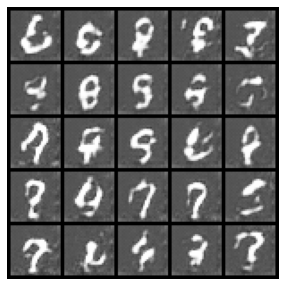

Imágenes reales


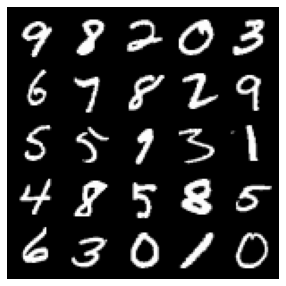

In [ ]:
#Obtener números aleatorios fijos que serán ingresados en el generador conforme avanza el entrenamiento
semilla_tf = obtener_ruido_tf(num_ejemplos, z_dim) 
#Entrenar la GAN
entrenamiento_tf(dataset_tf, numero_epocas)